In [3]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import galaxy

In [4]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [45]:
gals = {}
gals_iso = {}
for snap in tqdm(np.arange(0, 400+1)):
    try:
        gals[snap] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-steep1/output', 
                                   snap, orient=False)
    except:        
        pass
    
    try:
        gals_iso[snap] = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl5/output', snap, orient=False)
    except:
        print('loaded to snap=', snap-1)
        break

100%|██████████| 401/401 [03:05<00:00,  2.16it/s]


In [57]:
def get_inflow_outflow(gal, mass0, mass4, r0=15, dr=2, Rmax=12, zmax=3, subshell=False, print_shell=False):
    pos_center = gal.sub.SubhaloPos[0]
    vel_center = gal.sub.SubhaloVel[0]
    pos = gal.sn.part0.pos.value - pos_center
    vel = gal.sn.part0.vel.value - vel_center
    
    r = np.linalg.norm(pos, axis=1)
    in_shell = np.logical_and(r > r0-dr/2., r < r0 + dr/2.)
    
    rhat = pos / r[:,np.newaxis]
    vel_r = np.sum(vel * rhat, axis=1)

    is_inflow = np.logical_and(in_shell, vel_r < 0)
    inflow = np.sum(vel_r[is_inflow] * mass0[is_inflow])
        
    is_outflow = np.logical_and(in_shell, vel_r > 0)
    outflow = np.sum(vel_r[is_outflow] * mass0[is_outflow])
    
    print(np.median(vel_r[is_inflow]), np.percentile(vel_r[is_inflow], 5))
    print(np.median(vel_r[is_outflow]), np.percentile(vel_r[is_outflow], 95))
    
    if gal.sn.NumPart_Total[4] > 0:
        is_wind = gal.sn.part4.GFM_StellarFormationTime <= 0
        pos = gal.sn.part4.pos.value - pos_center
        vel = gal.sn.part4.vel.value - vel_center
    
        r = np.linalg.norm(pos, axis=1)
        in_shell = np.logical_and(r > r0-dr/2., r < r0 + dr/2.)
    
        rhat = pos / r[:,np.newaxis]
        vel_r = np.sum(vel * rhat, axis=1)

        is_inflow = np.logical_and(vel_r < 0, is_wind)
        inflow += np.sum(vel_r[is_inflow] * mass4[is_inflow])
        
        is_outflow = np.logical_and(vel_r > 0, is_wind)
        outflow += np.sum(vel_r[is_outflow] * mass4[is_outflow])
    
    inflow /= dr
    outflow /= dr
    
    return inflow, outflow

def loop_inflow_outflow(gals, r0=15, dr=2):
    out = {}
    out['Time'] = []
    out['Inflow'] = []
    out['Outflow'] = []
    out['FeInflow'] = []
    out['FeOutflow'] = []
    out['MgInflow'] = []
    out['MgOutflow'] = []
    
    for snap in tqdm(gals.keys()):
        gal = gals[snap]
        out['Time'].append(gal.sn.Time.value)
        
        mass0 = gal.sn.part0.mass.value * gal.sn.part0.PassiveScalars[:,0]
        if gal.sn.NumPart_Total[4] > 0:
            mass4 = gal.sn.part4.mass.value
        else:
            mass4 = None
        infl, outfl = get_inflow_outflow(gal, mass0, mass4, r0=r0, dr=dr)
        out['Inflow'].append(infl)
        out['Outflow'].append(outfl)
        
        mass0 = gal.sn.part0.GFM_Metals[:,8] * gal.sn.part0.mass.value * gal.sn.part0.PassiveScalars[:,0]
        if gal.sn.NumPart_Total[4] > 0:
            mass4 = gal.sn.part4.GFM_Metals[:,8] * gal.sn.part4.mass.value
        else:
            mass4 = None
        infl, outfl = get_inflow_outflow(gal, mass0, mass4, r0=r0, dr=dr)
        out['FeInflow'].append(infl)
        out['FeOutflow'].append(outfl)
        
        mass0 = gal.sn.part0.GFM_Metals[:,6] * gal.sn.part0.mass.value * gal.sn.part0.PassiveScalars[:,0]
        if gal.sn.NumPart_Total[4] > 0:
            mass4 = gal.sn.part4.GFM_Metals[:,6] * gal.sn.part4.mass.value
        else:
            mass4 = None
        infl, outfl = get_inflow_outflow(gal, mass0, mass4, r0=r0, dr=dr)
        out['MgInflow'].append(infl)
        out['MgOutflow'].append(outfl)
    
    for k in out.keys():
        out[k] = np.array(out[k])
    
    return out

In [58]:
flow = loop_inflow_outflow(gals, r0=20, dr=4)
flow_iso = loop_inflow_outflow(gals_iso, r0=20, dr=4)

# Time, Inflow, Outflow = [], [], []
# for snap in tqdm(gals.keys()):
#     # gals[snap].do_orient(rhalf_fac=2)
#     infl, outfl = get_inflow_outflow(gals[snap])
#     Inflow.append(infl)
#     Outflow.append(outfl)
#     Time.append(gals[snap].sn.Time.value)
# Time, Inflow, Outflow = np.array(Time), np.array(Inflow), np.array(Outflow)
    
# Time_iso, Inflow_iso, Outflow_iso = [], [], []
# for snap in tqdm(gals_iso.keys()):
#     # gals_iso[snap].do_orient(rhalf_fac=2)
#     infl, outfl = get_inflow_outflow(gals_iso[snap])
#     Inflow_iso.append(infl)
#     Outflow_iso.append(outfl)
#     Time_iso.append(gals_iso[snap].sn.Time.value)
# Time_iso, Inflow_iso, Outflow_iso = np.array(Time_iso), np.array(Inflow_iso), np.array(Outflow_iso)

  1%|          | 3/401 [00:00<00:16, 24.80it/s]

-3.913443609823047 -7.156375961740114
4.015885821106074 7.1907099644876595
-3.913443609823047 -7.156375961740114
4.015885821106074 7.1907099644876595
-3.913443609823047 -7.156375961740114
4.015885821106074 7.1907099644876595
-4.734229777584278 -8.55102495215695
3.2217846843181626 6.534258543981558
-4.734229777584278 -8.55102495215695
3.2217846843181626 6.534258543981558
-4.734229777584278 -8.55102495215695
3.2217846843181626 6.534258543981558
-6.820093791850789 -12.448067165390729
3.216054421574053 6.584869690904957
-6.820093791850789 -12.448067165390729
3.216054421574053 6.584869690904957
-6.820093791850789 -12.448067165390729
3.216054421574053 6.584869690904957
-9.227997872565396 -16.28239538992979
1.8373112689736724 4.3520472210031285
-9.227997872565396 -16.28239538992979
1.8373112689736724 4.3520472210031285
-9.227997872565396 -16.28239538992979
1.8373112689736724 4.3520472210031285
-13.490517798802136 -22.789788083057058
0.8117197812019924 2.346840390624544
-13.490517798802136 -22

/n/home01/abeane/venv/note/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home01/abeane/venv/note/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|          | 5/401 [00:00<00:19, 19.89it/s]


IndexError: index -1 is out of bounds for axis 0 with size 0

(1.0, 4.0)

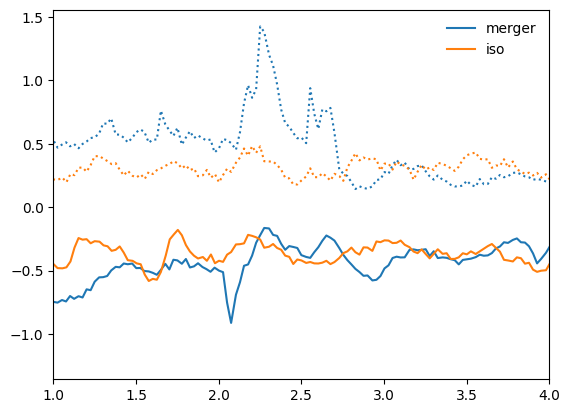

In [50]:
l = plt.plot(flow['Time'], flow['Inflow'], label='merger')
plt.plot(flow['Time'], flow['Outflow'], c=l[0].get_color(), ls='dotted')

l = plt.plot(flow_iso['Time'], flow_iso['Inflow'], label='iso')
plt.plot(flow_iso['Time'], flow_iso['Outflow'], c=l[0].get_color(), ls='dotted')

plt.legend(frameon=False)
plt.xlim(1, 4)

(-0.3, 0.3)

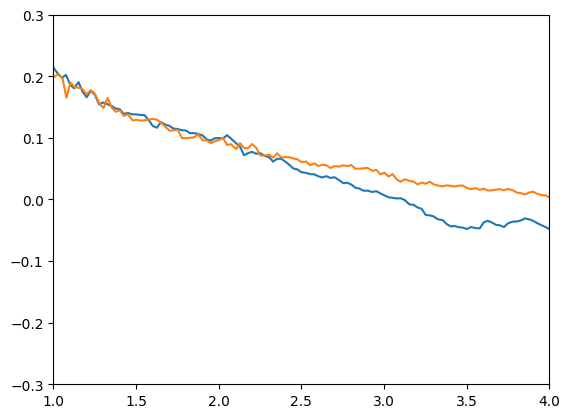

In [54]:
# plt.plot(flow['Time'], flow['FeOutflow']/flow['Outflow'])
# plt.plot(flow['Time'], flow['MgOutflow']/flow['Outflow'])
# plt.plot(flow['Time'], np.log10(flow['MgOutflow']/flow['FeOutflow']))
plt.plot(flow['Time'], np.log10(flow['MgInflow']/flow['FeInflow']))
plt.plot(flow_iso['Time'], np.log10(flow_iso['MgInflow']/flow_iso['FeInflow']))


plt.xlim(1, 4)
plt.ylim(-0.3, 0.3)

In [8]:
gal = gals[20]

vel_center = gal.sub.SubhaloVel[0]

rshell = 15
dr = 2

pos0 = gal.sn.part0.pos.value - gal.sub.SubhaloPos[0]
vel0 = gal.sn.part0.vel.value - vel_center
r0 = np.linalg.norm(pos0, axis=1)
rhat0 = gal.sn.part0.pos.value / r0[:,np.newaxis]
vel_r0 = np.sum(rhat0 * vel0, axis=1)

key = np.logical_and(r0 > rshell-dr/2., r0 < rshell+dr/2.)
is_inflow = np.logical_and(key, vel_r0 < 0)
is_outflow = np.logical_and(key, vel_r0 > 0)
Mdot_in = np.sum(gal.sn.part0.mass.value[is_inflow] * vel_r0[is_inflow]) / dr
Mdot_out = np.sum(gal.sn.part0.mass.value[is_outflow] * vel_r0[is_outflow]) / dr
print('Mdot_in=', Mdot_in)
print('Mdot_out=', Mdot_out)

Mdot_in= -28.49087748664808
Mdot_out= 8.755043877756377


In [9]:
Inflow[20]

NameError: name 'Inflow' is not defined

In [ ]:
    pos_center = gal.sub.SubhaloPos[0]
    vel_center = gal.sub.SubhaloVel[0]
    pos = gal.sn.part0.pos.value - pos_center
    vel = gal.sn.part0.vel.value - vel_center
    
    r = np.linalg.norm(pos, axis=1)
    in_shell = np.logical_and(r > r0-dr/2., r < r0 + dr/2.)
    
    rhat = pos / r[:,np.newaxis]
    vel_r = np.sum(vel * rhat, axis=1)

    is_inflow = vel_r < 0
    inflow = np.sum(vel_r[is_inflow] * gal.sn.part0.mass.value[is_inflow])
        
    is_outflow = vel_r > 0
    outflow = np.sum(vel_r[is_outflow] * gal.sn.part0.mass.value[is_outflow])